In [55]:
import sys
sys.path.append("..")
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from LowLevelModules.Spectroscopy import Spectrum
from scipy.optimize import curve_fit
from LowLevelModules.GeneralFunctions import get_work_dir, prettify_plot, prettify_2d_plot, voigt_func, voigt_func_2p
import numpy as np
import os
# user input
wdir = r'Z:\Projects\WSe2\2019\09 september\2019-09-04 WSe2hBN MANNP\5K spectra'
## fetch all SPE files in folder
files = [f for f in os.listdir(wdir) if '.spe' in f]
filenames = [f[:-4] for f in files if not 'raw' in f]
filenames

['WSe2hBN_MANNP_5K_60nW_bright_spot_ML_1 00',
 'WSe2hBN_MANNP_5K_60nW_bright_spot_ML_2 01',
 'WSe2hBN_MANNP_5K_700nW_bright_spot_ML_2 02',
 'WSe2hBN_MANNP_5K_60nW_bright_spot_ML_3 03',
 'WSe2hBN_MANNP_5K_700nW_bright_spot_ML_3 04',
 'WSe2hBN_MANNP_5K_60nW_bright_spot_ML_4 05',
 'WSe2hBN_MANNP_5K_60nW_bright_spot_ML_QD1 06',
 'WSe2hBN_MANNP_5K_6nW_bright_spot_ML_QD1 07',
 'WSe2hBN_MANNP_5K_700nW_bright_spot_ML_QD1 08',
 'WSe2hBN_MANNP_5K_60nW_bright_spot_ML_QD2 09',
 'WSe2hBN_MANNP_5K_6nW_bright_spot_ML_QD2 10',
 'WSe2hBN_MANNP_5K_700nW_bright_spot_ML_QD2 11',
 'WSe2hBN_MANNP_5K_60nW_bright_spot_ML_QD3 12',
 'WSe2hBN_MANNP_5K_6nW_bright_spot_ML_QD3 13',
 'WSe2hBN_MANNP_5K_700nW_bright_spot_ML_QD3 14']

In [2]:
import ipywidgets as widgets
from IPython.display import display
normalize_choice = widgets.Checkbox(
    value=False,
    description='Normalize and shift',
    disabled=False
)

etaloning_choice = widgets.Checkbox(
    value=True,
    description='Remove CCD etaloning',
    disabled=False
)
fit_choice = widgets.Checkbox(
    value=False,
    description='Fit data with 2 Voigt profiles',
    disabled=False
)

x_axis_choice = widgets.RadioButtons(
    options=['Wavelength (nm)', 'Energy (eV)'],
    value='Wavelength (nm)',
    description='X axis unit:',
    disabled=False
)
display(etaloning_choice)
display(normalize_choice)
display(fit_choice)
display(x_axis_choice)

Checkbox(value=True, description='Remove CCD etaloning')

Checkbox(value=False, description='Normalize and shift')

Checkbox(value=False, description='Fit data with 2 Voigt profiles')

RadioButtons(description='X axis unit:', options=('Wavelength (nm)', 'Energy (eV)'), value='Wavelength (nm)')

In [56]:
file_numbers = [13, 12, 14] #range(0,len(filenames))
legend_txt = ['6nW', '60nW', '700nW']  # leave empty [] if no legend
chosen_files = [filenames[i] for i in file_numbers]

<IPython.core.display.Javascript object>


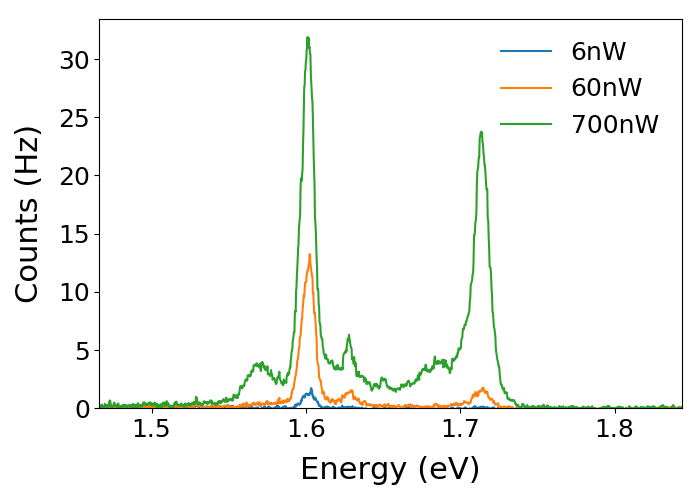

In [57]:
# fitting bounds on two peaks a01, x01, sigma1, gamma1, a02, x02, sigma2, gamma2
bds = ([.1, 700, 0.1, 0.1, 0.1, 700, 0.1, 0.1],[np.inf, 800, 50, 50, np.inf, 800, 50, 50])
volts = np.arange(-10,10.5,.5)
v_spacing = 1
#plot
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
cts = np.zeros(1340,)
nd_counts = []   # for the 2d voltage/spectra plot
max_spec = 1
for i, f in enumerate(chosen_files):
    # plot everything
    file = wdir + '\\' + f + '.spe'
    data = Spectrum(file)
    #data.remove_cosmic_ray(5)
    # put background to zero far off peaks
    data.y -= np.mean(data.y[:10])
    if etaloning_choice.value:
        data.remove_etaloning(0.3, 0.48, 0.02, plotplot=False)
    if x_axis_choice.value == 'Energy (eV)':
        data.x = 1241/data.x
        data.x = data.x[::-1]
        data.y = data.y[::-1]
    #nd_counts.append(data.y)
    if fit_choice.value:
        coeffs, _ = curve_fit(voigt_func_2p, data.x, data.y, bounds=bds)
        y_arrf = voigt_func_2p(data.x, *coeffs)
        y_arr1 = voigt_func(data.x, *coeffs[:4])
        y_arr2 = voigt_func(data.x, *coeffs[4:])
        max_spec = np.max(y_arrf)
        
    if normalize_choice.value:
        data.y = data.y / max_spec + i*v_spacing
    
    ax.plot(data.x, data.y, '-')
    if fit_choice.value:
        if normalize_choice.value:
            y_arrf = y_arrf / max_spec + i*v_spacing
            y_arr1 = y_arr1 / max_spec + i*v_spacing
            y_arr2 = y_arr2 / max_spec + i*v_spacing
        ax.plot(data.x, y_arrf, 'r')
        ax.fill(data.x, y_arr1, 'g', facecolor='green', alpha=0.1)
        ax.fill(data.x, y_arr2, 'g', facecolor='green', alpha=0.1)


#axis limits
plt.xlim(data.x[0], data.x[-1])
plt.ylim(0, 1.05*np.max(data.y))
#special cases
#plt.xlim(700, 820)
# plt.ylim(0, 3)

if legend_txt:
    ax.legend(legend_txt, prop={'size': 18}, frameon=False)
# if fit_choice.value:
#     plt.text(1.06*np.min(data.x), 0.95*np.max(data.y), "Peak 1 " + str(np.round(coeffs[1],2)) + " nm" , fontsize=18)
#     plt.text(1.06*np.min(data.x), 0.88*np.max(data.y), "Peak 2 " + str(np.round(coeffs[5],2)) + " nm" , fontsize=18)
y_axis_label = "Norm. counts" if normalize_choice.value else "Counts (Hz)"
prettify_plot(ax, x_axis_choice.value, y_axis_label)
fig.tight_layout()

In [13]:
fig.savefig(wdir + '\\' + f + x_axis_choice.value[:-4] + '.png', format='png', bbox_inches='tight')

In [60]:
y_arrf

array([0.00145615, 0.0014602 , 0.00146426, ..., 0.00232533, 0.00231713,
       0.00230898])

In [21]:
fig2.savefig(wdir + '\\' + f + '2dVoltagescan' + x_axis_choice.value[:-4] +'.png', format='png', bbox_inches='tight')

In [23]:
1.9*2.2

4.18